# Center of Gravity Method with Automatic Differentiation for Facility Location


---



---



### **Minimize total cost due to transport of units**
#### Cost Function $= \sum_i distance_i \times (\frac{cost}{distance \cdot unit})_i \times units_i$ where $distance_i$ is the distance between location $i$ and distribution center at iteration $t$

#### Lets define problem data

In [ ]:
from jax import grad, jit, vmap
import jax.numpy as np
import numpy as np2

#2D coordinates of locations of demand or supply
x_n = np.array([[-0.97,-80.7],
                [-1.05, -80.45],
               [-2.15, -79.92],
               [-1.81, -79.53],
               [-1.03, -79.47]])

#Quantities of demand/supply for each location
quantities = np.array([[250],[200],[700],[150],[300]]) 

#Cost/(unit x distance) from each location to depot/distribution center
costs = np.array([[1],[1],[1],[1],[1]])

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:127: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


#### Now we mus define the function which we want to minimize

In [ ]:
def distances(x,y):
  '''Function that return distance between two locations
      Input: Two 2D numpy arrays
      Output: Distance between locations'''

  x_rp = np.repeat(x,x_n.shape[0],0).reshape(-1,1)
  y_rp = np.repeat(y,x_n.shape[0],0).reshape(-1,1)
  dist_x = (x_rp - x_n[:,:1])**2
  dist_y = (y_rp - x_n[:,1:2])**2
  return np.sqrt(dist_x+dist_y).reshape((-1,1))

def cost_function(x_0):
  '''Function that calculate total cost due to transport for a depot/distribution center location x_0
      Input: 2D numpy array
      Output: Total cost'''
   
  x = np.array([[x_0[0,0]]])
  y = np.array([[x_0[0,1]]])

  dist            = distances(x,y)
  dist_costo = quantities*costs*dist

  return np.sum(dist_costo)

#### With the defined function we can calculate the gradient with JAX 

In [ ]:
gradient_funcion = jit(grad(cost_function)) #jit (just in time) compile makes faster the evaluation of the gradient.

#### Now lets define the procedure to apply gradient descent or newton nethod

In [ ]:
def optimize(funtion_opt, grad_fun, x_0, method, n_iter):
  '''Input:
      funtion_opt: Function  to minimize
     grad_fun: gradient of the function to minimize
     x_0: initial 2D coordiantes of depot/distribution center
     method: method to use for minimize
     n_iter: Number of iterations of the method
                               --------------
     Output:
     xs: List of x coordiantes for each iteration
     ys: List of y coordiantes for each iteration
     fs: List of costs for each iteration'''

  #Create empty lists to fill with iteration values
  xs  = [] 
  ys  = []
  fs   = []

  #Add the initial location
  xs.append(x_0[0,0])
  ys.append(x_0[0,1])
  fs.append(cost_function(x_0))

  for i in range(n_iter):
    
    if method == 'newton':
      loss_val = funtion_opt(x_0)
      loss_vec  = np.array([[loss_val, loss_val]])
      x_0 -= 0.005*loss_vec/grad_fun(x_0)
    elif method == 'grad_desc':
      step = 0.0001*grad_fun(x_0)
      x_0 -= step
      
    xs.append(x_0[0,0])
    ys.append(x_0[0,1])
    fs.append(cost_function(x_0))
  return xs, ys, fs

#### Lets minimize with gradient descent

In [ ]:
#Initial locationl of depots/distribution centers
x0=np.array([[4.0,-84.0]])

print("Initial Cost: {:0.2f}".format(cost_function(x0 )  ))

xs, ys, fs = optimize(cost_function, gradient_funcion, x0, 'grad_desc', 100)

print("Final Cost: {:0.2f}".format(fs[-1]))

Initial Cost: 11022.59
Final Cost: 1031.51


Now lets plot the trayectory of the optimization procedure.

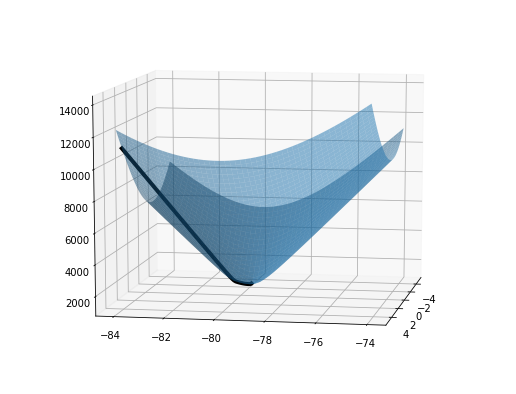

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#We must modified how we feed the input to the cost function to plot values of x and y coordinates
def cost_function_2(x,y):
  dist            = distances(x,y)
  dist_costo = quantities*costs*dist
  return np.sum(dist_costo)

FIGSIZE = (9, 7)

xs = np.array(xs).reshape(-1,)
ys = np.array(ys).reshape(-1,)
fs = np.array(fs)


X, Y          = np2.meshgrid(np2.linspace(-5., 5., 50), np2.linspace(-84., -74., 50))
func_vec = np2.vectorize(cost_function_2)
f               = func_vec(X,Y)
indices    = (slice(None, None, 4), slice(None, None, 4))

fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d', azim=10,elev=10)
ax.plot_surface(X, Y, f, shade=True, linewidth=2, antialiased=True,alpha=0.5)
ax.plot3D(xs, ys, fs, color='black', lw=4)